# Final Project - Bayesian model selection

In [1]:
import arviz as az
import numpy as np
import pymc3 as pm

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.special import betaln
from scipy.stats import beta
from scipy.stats import norm
from functions import beauty_plot
from functions import beauty_settings

In [2]:
np.random.seed(11)           # for reproducibility
a=0.25                       # biased coin
flips=np.random.rand(2**12)  # simulates 4096 coin flips
heads=flips<a    # boolean array, heads[i]=True if flip i is heads
np.sum(heads)

983

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.385
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.394
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000


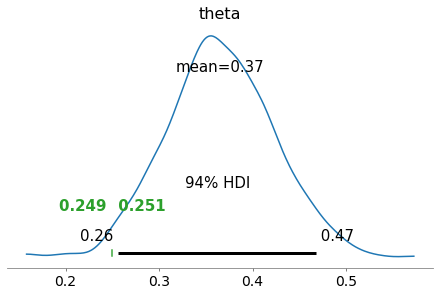

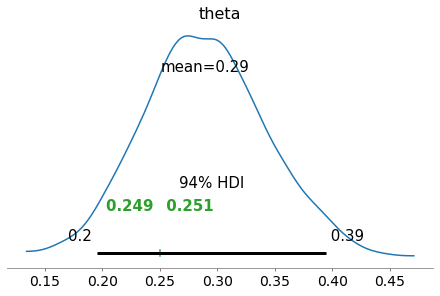

In [3]:
with pm.Model() as model1: #model of a fair coin
    theta = pm.Normal("theta",mu=.5,sigma=.1) #prior for the parameter theta
    yl = pm.Bernoulli("yl", theta, observed=heads[:50]) #likelihood given the measured data
    trace1 = pm.sample_smc(1000, random_seed=42, parallel=False) #sample from posterior
with pm.Model() as model2: #model of biased coin  
    theta = pm.Normal("theta",mu=.25,sigma=.1) #prior for the parameter theta
    yl = pm.Bernoulli("yl", theta, observed=heads[:50]) #likelihood given the measured data
    trace2 = pm.sample_smc(1000, random_seed=42, parallel=False) #sample from posterior
with model1:
    az.plot_posterior(trace1,rope=[0.249,0.251])
with model2:
    az.plot_posterior(trace2,rope=[0.249,0.251])


In [4]:
BF_smc = np.exp(trace2.report.log_marginal_likelihood - trace1.report.log_marginal_likelihood)#bayes factor
BF_smc

array([3.47885066, 3.52248701])

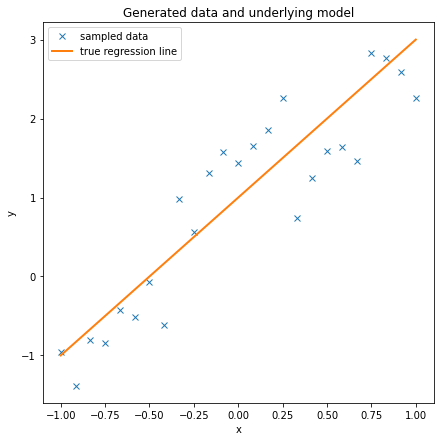

In [5]:
size = 25 #no of datapoints
true_intercept = 1 
true_slope = 2
#true_sq=2
sigma=1/2 #noise

x = np.linspace(-1, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x#+2*x**2
# add noise
y = true_regression_line + np.random.normal(scale=sigma, size=size)

data = dict(x=x, y=y)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);


In [6]:
sampleSize = 1000 #no. of samples that will be drawn from the posterior
prior_sigma = 2
with pm.Model() as lin_model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
    m = pm.Normal("m", 0, sigma=prior_sigma)
    
    mu = pm.Deterministic('mu', intercept + m * x)
    # Define likelihood
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    # Inference!
    lin_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 

with pm.Model() as const_model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
    # Define likelihood
    mu = pm.Deterministic('mu', intercept+x*0)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    # Inference!
    const_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 
    
with pm.Model() as sq_model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    #sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
    a = pm.Normal("a", 0, sigma=prior_sigma)
    b = pm.Normal("b", 0, sigma=prior_sigma)
    
    # Define likelihood
    mu = pm.Deterministic('mu', intercept+x*b+a*x**2)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    # Inference!
    sq_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 
with pm.Model() as cub_model:
    #define priors
    intercept = pm.Normal("Intercept", 0, sigma=prior_sigma)
    a = pm.Normal("a", 0, sigma=prior_sigma)
    b = pm.Normal("b", 0, sigma=prior_sigma)
    c = pm.Normal("c", 0, sigma=prior_sigma)
    #define likelihood
    mu = pm.Deterministic('mu', intercept+c*x+b*x**2+a*x**3)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    # Inference!
    cub_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 
#note: sampled parameters are saved in a trace object, therefore we n

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.027
Stage:   2 Beta: 0.097
Stage:   3 Beta: 0.337
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.027
Stage:   2 Beta: 0.097
Stage:   3 Beta: 0.337
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.107
Stage:   2 Beta: 0.828
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.108
Stage:   2 Beta: 0.866
Stage:   3 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.021
Stage:   2 Beta: 0.062
Stage:   3 Beta: 0.174
Stage:   4 Beta: 0.458
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.022
Stage:   2 Beta: 0.064
Stage:   3 Beta: 0.177
Stage:   4 Beta: 0.466
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.005
Stage:   1 Beta: 0.021
Stage:   2 Beta: 0.065
Stage:   3 Beta: 

In [ ]:
#plot the marginal posteriors for each sampled parameter, this is done by arviz 
with lin_model:
    az.plot_posterior(lin_trace, var_names=['Intercept', 'm'])

with sq_model:
    az.plot_posterior(sq_trace, var_names=['Intercept', 'a', 'b'])    

with const_model:
    az.plot_posterior(const_trace, var_names=['Intercept'])
with cub_model:
    az.plot_posterior(cub_trace, var_names=['Intercept', 'a','b','c'])
    

In [ ]:
#now lets check what we just sampled
#first we plot our data again
#now plot the models and indicate the highest probability density region of 99%, this is taken care of by az.plot_hpd
# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(20,6))
ax1.plot(x, y,"x",label="data")
ax1.plot(x,true_regression_line,label="true regression line",c="r")
az.plot_hdi(x, lin_trace['mu'], hdi_prob=.99, color='g',ax=ax1)
ax1.set_title('Linear model fit')

ax2.plot(x, y,"x",label="data")
ax2.plot(x,true_regression_line,label="true regression line",c="r")
az.plot_hdi(x, sq_trace['mu'], hdi_prob=.99, color='b',ax=ax2)

ax2.set_title('Quadratic model fit')
ax3.plot(x, y,"x",label="data")
ax3.plot(x,true_regression_line,label="true regression line",c="r")
az.plot_hdi(x, cub_trace['mu'], hdi_prob=.99, color='y',ax=ax3)
ax3.set_title('Cubic model fit')
ax1.grid()
ax1.legend()
# where some data has already been plotted to ax
handles, labels = ax1.get_legend_handles_labels()
# manually define a new patch 
patch = mpatches.Patch(color='g',alpha=0.5,label='HDI lin')
# handles is a list, so append manual patch
handles.append(patch) 
# plot the legend
ax1.legend(handles=handles,bbox_to_anchor=(1,-0.2), ncol=1)
ax2.grid()
ax2.legend()
# where some data has already been plotted to ax
handles, labels = ax2.get_legend_handles_labels()
# manually define a new patch 
patch = mpatches.Patch(color='b',alpha=0.5,label='HDI quad')
# handles is a list, so append manual patch
handles.append(patch) 
# plot the legend
ax2.legend(handles=handles,bbox_to_anchor=(1,-0.2), ncol=1)
#ax3.legend(loc="")
ax3.grid()
# where some data has already been plotted to ax
handles, labels = ax3.get_legend_handles_labels()
# manually define a new patch 
patch = mpatches.Patch(color='y',alpha=0.5,label='HDI cub')
# handles is a list, so append manual patch
handles.append(patch) 
# plot the legend
ax3.legend(handles=handles,bbox_to_anchor=(1,-0.2), ncol=1)


ax1.set_xlabel("x")
ax1.set_ylabel("y");
ax2.set_xlabel("x")
ax2.set_ylabel("y");
ax3.set_xlabel("x")
ax3.set_ylabel("y");
plt.show()
f.savefig("tolplot.pdf")



In [ ]:
def Bayes_Factor(trace1, trace2):
    return  np.exp(trace1.report.log_marginal_likelihood - trace2.report.log_marginal_likelihood)#bayes factor
def log_bayes_factor(trace1,trace2):
     return  (trace1.report.log_marginal_likelihood - trace2.report.log_marginal_likelihood)#bayes factor

In [ ]:
Bayes_Factor(lin_trace, sq_trace)

## Savage Dickey Density Ratio (SDDR)

In [ ]:
def find_y_for_x(x, y, value):
    i = 0
    while i != len(x):
        if x[i]<= value and x[i+1]>= value:
            break
        i+=1
    return y[i]

def trace_extractor(trace, param_name,title):
    plt.figure(figsize=(12,6))
    bins = 100
    trace_param = trace[param_name]#extract parameter from trace
    hist_tmp = np.histogram(trace_param, bins=bins)#make histo
    hist = [hist_tmp[0]/np.sum(hist_tmp[0]), hist_tmp[1]] #normalize histo
    print("Integral: ",np.sum(hist[0]))#check normalization
    plt.plot(hist[1][:-1], hist[0],".", label = "$p(\omega|D,M_2)$")#plot
    #generate prior distribution
    sigma = prior_sigma
    mu = 0
    bin_per_x=(np.amax(hist[1])-np.amin(hist[1]))/bins # to compare histos with function multiply by this
    x_val = np.linspace(-5,5,100)
    y_val=norm(loc=0,scale=prior_sigma)
    y_val=y_val.pdf(x_val)*bin_per_x
    
    plt.plot(x_val, 3*y_val,".", label = "$p(\omega|M_2)$")#scale the prior so it looks nicer
    plt.vlines(x=0, ymin=0, ymax=np.amax(hist[0])*1.05, color="r", ls="--", label = "$\omega_*$")
    y_found = find_y_for_x(hist[1][:-1], hist[0], 0)
    y_prior = find_y_for_x(x_val, y_val, 0)
    print("SDDR: ",y_found/y_prior)
    #plt.hlines(y=y_found, xmin=np.amin(hist[1][:-1])*10,xmax=np.amax(hist[1][:-1])*10, ls="--",color="black", label = "$p(\omega=\omega_*|D,M_2)$")
    #plt.hlines(y=y_prior, xmin=np.amin(hist[1][:-1])*10,xmax=np.amax(hist[1][:-1])*10, ls="-.",color="darkblue", label = "$p(\omega=\omega_*|M_2)$")
    beauty_settings()
    plt.legend(bbox_to_anchor=(1.4,1), ncol=1)
    plt.xlabel("$\omega$")
    plt.title(title)
    plt.show()
    return y_found

y1=trace_extractor(sq_trace,"a",'linear vs. squared')
y2=trace_extractor(cub_trace,"a",'squared vs. cubic')



## Bayes Complexity

In [ ]:
#for now lets assume we look at a polynomial of degree n and want to compute the bayesian complexity like Kunz et. al.

def poly_model(x,params): #params is array from highest order to lowest order of coefficents
    return np.polyval(params, x) # we look at polynomials of degree n where n is determined by the length of the params array

def logli(sigma,datapoints_x,datapoints_y,params): # we compute chi^2 but name it logli
    N=len(datapoints_x)
    loglikelihood=0
    for i in range(len(datapoints_x)):
        loglikelihood+=(datapoints_y[i]-poly_model(datapoints_x[i],params))**2/(sigma**2)#sum all chi^2 values for the datapoints (x,y)
    return loglikelihood

def bayes_complexity(datapoints_x,datapoints_y,sigma,params,trace):#params is a list of strings with parameter NAMES
    param_means=np.array([np.mean(trace[i])for i in params])#compute the mean of all sampled parameters
    param_samples=np.array([trace[i] for i in params])#extract sampled parameter values in array (with lists) param_samples, this has numberofparams*numberofsamples entries
    loglikelihood=logli(sigma,datapoints_x,datapoints_y,param_samples)#create an array loglikelihood (which is chi^2) each entry is determined by a sampled parameter-vector
    mean_loglikelihood=logli(sigma,datapoints_x,datapoints_y,param_means)#compute ONE value for chi^2 with the means of all parameters
    return (np.mean(loglikelihood)-mean_loglikelihood) #build mean of loglikelihood wrt to the samples and substract the loglikelihood computed from the mean parametervalues



In [ ]:
#### Code without the python advantages ;) step by step, it yields the same results! note how the above solution is much more elegant and shorter
def poly_model(x,params): #params is array from highest order to lowest order of coefficents
    return np.polyval(params, x)#return polynom of ordern len(params)

def chi_sq(data_x,data_y,sigma,params): #this calculates chi^2 for ONE set of params for all data points
    chi = 0
    #print(params[0])
    for i in range(len(data_x)):
        chi+=(data_y[i]-(poly_model(data_x[i], params)))**2/(sigma**2) #plug in definition and profit
    return chi

def chi_sq_mean(data_x,data_y,sigma,trace,param_names): # this calculates the mean \bar{chi^2} wrt the posterior
    chi_sum = 0
    param_samples =np.array([trace[i] for i in param_names]) #params is array from highest order to lowest order of coefficents 
    #we now have an array with numberofparams * numberofsamples entries 
    #print(param_samples[0][0])
    for t in range(len(param_samples[0])):
        chi_sum += chi_sq(data_x,data_y,sigma, [param_samples[i][t] for i in range(len(param_names))])#pick out the parameter samples at place t from parameter i 
    chi_mean = chi_sum/(len(param_samples[0]))#build mean by normalizing
    return chi_mean

def mean_params_chi(data_x,data_y,sigma,trace,param_names):#this calculates the chi^2 value for theta_hat, in our case the mean of each sampled value, see posterior dist. above
    param_means=np.array([np.mean(trace[i])for i in param_names])#use np.mean() to calculate mean
    return chi_sq(data_x,data_y,sigma, param_means)#return chi^2(theta_hat)

def bayes_complexity_c(data_x,data_y,sigma,trace, param_names):
    return chi_sq_mean(data_x,data_y,sigma,trace, param_names)-mean_params_chi(data_x,data_y,sigma,trace,param_names)#this is the complexity which we want to calculate all along


## Results of Complexity and Bayes Factors

In [ ]:
beauty_plot()
const_params=['Intercept']
cub_params=['a','b','c','Intercept']
sq_params=['a','b','Intercept']
lin_params=['m','Intercept']

traces=[const_trace,lin_trace,sq_trace,cub_trace]
param_list_list=[const_params,lin_params,sq_params,cub_params]
complexity_list=[]
for i in range(0,4):
    complexity_list.append(bayes_complexity(x,y,sigma,param_list_list[i],traces[i]))

xx=[1,2,3,4]
yy=xx
plt.plot(xx,complexity_list,'b^', label="MC estimate")
plt.plot(xx,yy,'b--',label="$\mathcal{C}_b=\mathcal{C}_0$")
plt.xlabel('# of input parameters')
plt.ylabel('Effective complexity $\mathcal{C}_b$')
#plt.savefig('complexity.pdf')
plt.legend(bbox_to_anchor=(1,1), ncol=1)
plt.show()

In [ ]:
test = [np.array([1,2,3,4]),np.array([5,6,7])]
print(test)
test[0]=[8,9,10]
print(test[0])

## Experimental.... not working